In [10]:
from __future__ import division

import os, sys
from ctypes import *
import math
import random
import glob
import tqdm
import numpy as np
from matplotlib import image as mat_image, patches, pyplot as plt
import multiprocessing as mp
from PIL import Image

# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'darknet'))

from sample import Sample

class YOLODetector(object):
    # Attributes
    __path = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'darknet')
    __cfg_path = None
    __model_path = None
    __dat_path = None
    __net, __meta = None, None
    
    # Initializer
    def __init__(self, cfg, model, dat):
        __path = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'darknet')
        self.__cfg_path = bytes(os.path.join(__path,"cfg", cfg), 'utf-8')
        self.__model_path = bytes(os.path.join(__path,"backup", model), 'utf-8')
        self.__dat_path = bytes(os.path.join(__path,"cfg", dat), 'utf-8')
    
        class BOX(Structure):
            _fields_ = [("x", c_float),
                            ("y", c_float),
                            ("w", c_float),
                            ("h", c_float)]

        class DETECTION(Structure):
            _fields_ = [("bbox", BOX),
                            ("classes", c_int),
                            ("prob", POINTER(c_float)),
                            ("mask", POINTER(c_float)),
                            ("objectness", c_float),
                            ("sort_class", c_int)]

        class IMAGE(Structure):
            _fields_ = [("w", c_int),
                            ("h", c_int),
                            ("c", c_int),
                            ("data", POINTER(c_float))]

        class METADATA(Structure):
            _fields_ = [("classes", c_int),
                        ("names", POINTER(c_char_p))]

         # SETUP
        lib = CDLL(os.path.join(__path,"libdarknet.so"), RTLD_GLOBAL)
        lib.network_width.argtypes = [c_void_p]
        lib.network_width.restype = c_int
        lib.network_height.argtypes = [c_void_p]
        lib.network_height.restype = c_int
        self.lib = lib
        
        predict = self.lib.network_predict
        predict.argtypes = [c_void_p, POINTER(c_float)]
        predict.restype = POINTER(c_float)
        self.predict = predict

        set_gpu = self.lib.cuda_set_device
        set_gpu.argtypes = [c_int]
        self.set_gpu = set_gpu
        
        make_image = self.lib.make_image
        make_image.argtypes = [c_int, c_int, c_int]
        make_image.restype = IMAGE
        self.make_image = make_image
        
        get_network_boxes = self.lib.get_network_boxes
        get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int)]
        get_network_boxes.restype = POINTER(DETECTION)
        self.get_network_boxes = get_network_boxes
        
        
        make_network_boxes = self.lib.make_network_boxes
        make_network_boxes.argtypes = [c_void_p]
        make_network_boxes.restype = POINTER(DETECTION)
        self.make_network_boxes = make_network_boxes
        
        free_detections = self.lib.free_detections
        free_detections.argtypes = [POINTER(DETECTION), c_int]
        self.free_detections = free_detections
        
        free_ptrs = self.lib.free_ptrs
        free_ptrs.argtypes = [POINTER(c_void_p), c_int]
        self.free_ptrs = free_ptrs
        
        network_predict = self.lib.network_predict
        network_predict.argtypes = [c_void_p, POINTER(c_float)]
        self.network_predict = network_predict
        
        reset_rnn = self.lib.reset_rnn
        reset_rnn.argtypes = [c_void_p]
        self.reset_rnn = reset_rnn
        
        load_net = self.lib.load_network
        load_net.argtypes = [c_char_p, c_char_p, c_int]
        load_net.restype = c_void_p
        self.load_net = load_net
    
        do_nms_obj = self.lib.do_nms_obj
        do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]
        self.do_nms_obj = do_nms_obj
        
        do_nms_sort = self.lib.do_nms_sort
        do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]
        self.do_nms_sort = do_nms_sort

        free_image = self.lib.free_image
        free_image.argtypes = [IMAGE]
        self.free_image = free_image

        letterbox_image = self.lib.letterbox_image
        letterbox_image.argtypes = [IMAGE, c_int, c_int]
        letterbox_image.restype = IMAGE
        self.letterbox_image = letterbox_image
        
        load_meta = self.lib.get_metadata
        self.lib.get_metadata.argtypes = [c_char_p]
        self.lib.get_metadata.restype = METADATA
        self.load_meta = load_meta

        load_image = self.lib.load_image_color
        load_image.argtypes = [c_char_p, c_int, c_int]
        load_image.restype = IMAGE
        self.load_image = load_image

        rgbgr_image = self.lib.rgbgr_image
        rgbgr_image.argtypes = [IMAGE]
        self.rgbgr_image = rgbgr_image
        
        predict_image = self.lib.network_predict_image
        predict_image.argtypes = [c_void_p, IMAGE]
        predict_image.restype = POINTER(c_float)
        self.predict_image = predict_image
        
    def sample(probs):
        s = sum(probs)
        probs = [a/s for a in probs]
        r = random.uniform(0, 1)
        for i in range(len(probs)):
            r = r - probs[i]
            if r <= 0:
                return i
        return len(probs)-1

    def c_array(ctype, values):
        arr = (ctype*len(values))()
        arr[:] = values
        return arr
    
    def classify(net, meta, im):
        out = self.predict_image(net, im)
        res = []
        for i in range(meta.classes):
            res.append((meta.names[i], out[i]))
        res = sorted(res, key=lambda x: -x[1])
        return res

    def load_model(self):
        self.__net = self.load_net(self.__cfg_path, self.__model_path, 0)
        self.__meta = self.load_meta(self.__dat_path)
    
    def detect(self, image, thresh=.5, hier_thresh=.5, nms=.45):
        """Apply YOLO to the image"""
        net = self.__net
        meta = self.__meta
        im = self.load_image(image, 0, 0)
        num = c_int(0)
        pnum = pointer(num)
        self.predict_image(net, im)
        dets = self.get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum)
        num = pnum[0]
        if (nms): self.do_nms_obj(dets, num, meta.classes, nms);
        res = []
        for j in range(num):
            for i in range(meta.classes):
                if dets[j].prob[i] > 0:
                    b = dets[j].bbox
                    res.append((meta.names[i], dets[j].prob[i], (b.x, b.y, b.w, b.h)))
        res = sorted(res, key=lambda x: -x[1])
        self.free_image(im)
        self.free_detections(dets, num)
        return res
    
    def yolo_labelled_img(self, image):
        """Plot the data and the corresponding label and boxes"""
        fig, ax = plt.subplots(1)
        labels = self.detect(bytes(image,'utf-8'))
        im_data = mat_image.imread(image)
        ax.imshow(im_data)
        for label in labels:
            color = 'cornflowerblue' if label[0]==b'Whistler' else 'lightcoral'
            event = label[0].decode("utf-8") 
            prob = label[1]
            x,y,w,h = label[2][0], label[2][1], label[2][2], label[2][3] 
            t_size, f_size = im_data.shape
            x1 = int((x-w/2))
            x2 = int((x+w/2))
            y1 = int((y-h/2))
            y2 = int((y+h/2))
            print(im_data.shape, x,y,w,h,x1,x2,y1,y2)
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor=color, facecolor='none')
            ax.text(x1,y2,str(event)+' p='+str(round(prob,3)), fontsize=12, bbox={'facecolor':color, 'pad':2, 'ec':color})
            ax.add_patch(rect)
        plt.show()
    


[(b'Whistler', 0.9999839067459106, (296.91522216796875, 36.87737274169922, 256.4022216796875, 57.73725509643555)), (b'Noise', 0.9995815753936768, (82.08820343017578, 3.656412124633789, 157.72279357910156, 6.024044513702393)), (b'Noise', 0.9948626756668091, (452.6398010253906, 97.95703887939453, 30.987503051757812, 60.09650421142578))]
(129, 469) 296.91522216796875 36.87737274169922 256.4022216796875 57.73725509643555 168 425 8 65
(129, 469) 82.08820343017578 3.656412124633789 157.72279357910156 6.024044513702393 3 160 0 6
(129, 469) 452.6398010253906 97.95703887939453 30.987503051757812 60.09650421142578 437 468 67 128


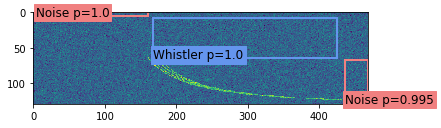

In [11]:
cfg="obj.cfg"
model="yolov3-tiny_40000.weights"
dat="obj.data"
yolo = YOLODetector(cfg, model, dat)
yolo.load_model()
r = yolo.detect( b"/home/othniel/wdml/darknet/yolo_data/data/0.35_80.0_5_4_2.23_25000_1000_10000_1.536_0.416.jpg")
print(r)
yolo.yolo_labelled_img( "/home/othniel/wdml/darknet/yolo_data/data/0.35_80.0_5_4_2.23_25000_1000_10000_1.536_0.416.jpg")